### 기본 세팅

In [4]:
import pandas as pd
import numpy as np
import pickle
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from konlpy.tag import Okt
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Hannanum
okt = Okt()
kkma = Kkma()
komoran = Komoran()
hannanum = Hannanum()

### 통합된 데이터 불러오기

In [8]:
data = pd.read_csv('./data_mbticafe.csv')
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
data

,articleid,mbti,title,content,menu_id
0,277264,estj,Estj istj 차이는 뭘까요?,['저는 estj인데 istj 특징을 보면 별로 저랑 다르지않은것같아요. 제 주변에...,11
1,277263,istj,블루스 추천,"[""동영상\n\n\nGrover Washington Jr. - Ain't No Su...",11
2,277216,enfp,ENFP 여자 ESTJ 남자친구랑 오래갈 수 있을까요 ㅠㅠ,['안녕하세요 ENFP 여자입니다 ㅠㅠ매번 짧고 금방 식는 연애만 해 왔는데지금 남...,11
3,276899,istj,생각에 확신이 없는 ISTJ,"['직장밴드에 이해하기 애매한 글이 올라왔어요.제 생각에는 찬성, 반대로만 물으면 ...",11
4,276311,estj,원하는 연애스타일 있으신가요?,"[""저는 개인적으로 알콩달콩도 좋지만 '레드벨벳-싸이코' 노래같은 그런연애 해보고 ...",11
...,...,...,...,...,...
48374,468294,infp,infp 분들 어릴때 환경 어땠나요 ?,['\u200b요즘 제가 교회에서 하는 연애•결혼 예비학교 강의를 듣는데 자존감이 ...,18
48375,468184,infp,마음이 너무 약해서 힘들어요..,['사실 이건 제가 불건강 인프피라서 그런 거 같기도 한데말 하나하나에 너무 예민하...,18
48376,468158,enfj,enfp분들 운전은 잘 하시나요?,['면허따려고 하는데..겁도 나고..(너무 신나게 달릴까봐요 ㅋㅋㅋ)\u200b물론...,18
48377,468061,infp,엔프피 주목! 인티제의 귀여운 점,['걸어가면서 생각하다가 정신팔려서 나뭇가지에 걸림\u200b혼자서 웃긴 생각하다가...,18


### 전처리 함수

In [13]:
# 전처리 함수 정의
def cleansing(text):  

    # 텍스트 길이 단축
    text = text[2:-2]
    
    # 줄바꿈 표현 제거
    text = re.sub(r'[\\n]+', '', text)
    text = re.sub(re.compile(r'\s+'), ' ', text)
    text = re.sub('([u200b]+)', ' ', text)
    text = re.sub('[\r|\n]', ' ', text)
     
    # 이메일 제거
    text = re.sub('([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+\.[a-zA-Z0-9-.]+)', ' ', text)
    
    # url 제거
    text = re.sub('www.(?:[-\w.]|(?:\da-fA-F]{2}))+', ' ', text)
    text = re.sub('(http|ftp|https)://(?:[-\w.]|(?:\da-fA-F]{3}))+', ' ', text)  
     
    # 괄호 안 내용 제거
    text = re.sub(r'\([^)]*\)', ' ', str(text)) 
    text = re.sub(r'\[[^]]*\]', ' ', text)
    
    # 특수기호 포함 내용 제거
    text = re.sub('\d\W', ' ', text)
    text = re.sub('[^\w\s\.\,\%\~]', ' ', text)
    text = re.sub('[^\w\s]', ' ', text)
    
    # 한글 자음, 모음 제거
    text = re.sub('([ㄱ-ㅎㅏ-ㅣ]+)', ' ', text)

    # MBTI 연관어 원래대로 변형    
    text = re.sub('인프피|인픞', 'infp', text)
    text = re.sub('엔프피|엔픞', 'enfp', text)
    text = re.sub('인팁', 'intp', text)
    text = re.sub('엔팁', 'entp', text)
    text = re.sub('잇프피|잇픞', 'isfp', text)
    text = re.sub('엣프피|엣픞', 'esfp', text)
    text = re.sub('잇팁', 'istp', text)
    text = re.sub('엣팁', 'estp', text)
    text = re.sub('인프제', 'infj', text)
    text = re.sub('엔프제', 'enfj', text)
    text = re.sub('잇프제', 'isfj', text)
    text = re.sub('엣프제', 'esfj', text)
    text = re.sub('인티제', 'intj', text)
    text = re.sub('엔티제', 'entj', text)
    text = re.sub('잇티제|이티제', 'istj', text)
    text = re.sub('엣티제|에스티제', 'estj', text)
    
    # MBTI 단어 제거
    text = re.sub('enfj|enfp|entj|entp|esfj|esfp|estj|estp|infj|infp|intj|intp|isfj|isfp|istj|istp', ' ', text)
    
    return(text)

In [16]:
data1=data.copy()
for i in tqdm(range(len(data1))):
    data1.loc[i,'content']=cleansing(data1.loc[i,'content']) # 정규표현식
#     data1.loc[i,'content']=okt.normalize(data1.loc[i,'content']) # 다듬기

100%|███████████████████████████████████████████████████████████████████████████| 48379/48379 [01:21<00:00, 591.15it/s]


content 길이 최댓값: 42833
content 길이 최솟값: 0
content 길이 평균값: 334.8693441369189
content 길이 중간값: 136.0


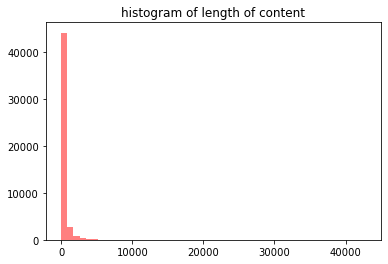

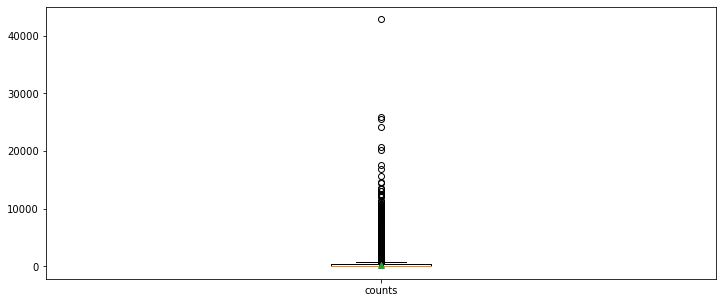

In [17]:
# 본문 길이 시각화
length=data1['content'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('histogram of length of content')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('content 길이 최댓값: {}'.format(np.max(length)))
print('content 길이 최솟값: {}'.format(np.min(length)))
print('content 길이 평균값: {}'.format(np.mean(length)))
print('content 길이 중간값: {}'.format(np.median(length)))

In [18]:
# content 길이 10퍼센트 미만인 글 제거
data1.drop(data1[length<np.percentile(length,10)].index, inplace=True)
data1=data1.reset_index().drop(['index'], axis=1)

In [19]:
data2=data1.copy()

In [20]:
def replace_mbti(text):
    pattern = '인프피|인픞' 
    text = re.sub(pattern=pattern,repl='INFP',string=text)
    
    pattern = '엔프피|엔픞' 
    text = re.sub(pattern=pattern,repl='ENFP',string=text)
    
    pattern = '인팁' 
    text = re.sub(pattern=pattern,repl='INTP',string=text)
    
    pattern = '엔팁' # 엔 팁
    text = re.sub(pattern=pattern,repl='ENTP',string=text)
    
    pattern = '잇프피|잇픞' 
    text = re.sub(pattern=pattern,repl='ISFP',string=text)
    
    pattern = '엣프피|엣픞' 
    text = re.sub(pattern=pattern,repl='ESFP',string=text)
    
    pattern = '잇팁' 
    text = re.sub(pattern=pattern,repl='ISTP',string=text)
    
    pattern = '엣팁' 
    text = re.sub(pattern=pattern,repl='ESTP',string=text)
    
    pattern = '인프제' 
    text = re.sub(pattern=pattern,repl='INFJ',string=text)
    
    pattern = '엔프제' 
    text = re.sub(pattern=pattern,repl='ENFJ',string=text)
    
    pattern = '잇프제' 
    text = re.sub(pattern=pattern,repl='ISFJ',string=text)
    
    pattern = '엣프제' 
    text = re.sub(pattern=pattern,repl='ESFJ',string=text)
    
    pattern = '인티제' 
    text = re.sub(pattern=pattern,repl='INTJ',string=text)
    
    pattern = '엔티제' 
    text = re.sub(pattern=pattern,repl='ENTJ',string=text)
    
    pattern = '잇티제|이티제' # 이티제
    text = re.sub(pattern=pattern,repl='ISTJ',string=text)
    
    pattern = '엣티제|에스티제' # 에스티제
    text = re.sub(pattern=pattern,repl='ESTJ',string=text)
    
    return (text)

In [21]:
for i in tqdm(range(len(data2))):
    data2.loc[i,'mbti']=replace_mbti(data2.loc[i,'mbti'])
    data2.loc[i,'mbti']=data2.loc[i,'mbti'].lower()

100%|███████████████████████████████████████████████████████████████████████████| 43663/43663 [00:53<00:00, 813.66it/s]


### 데이터 라벨링

In [22]:
# labeling 16개 (0-15)
encoder=LabelEncoder()
data2['mbti_label']=encoder.fit_transform(data2['mbti'])

In [23]:
# map (0-15)
encoder.classes_

array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object)

In [24]:
# labeling binary
e=[0,1,2,3,4,5,6,7] 
n=[0,1,2,3,8,9,10,11] 
f=[0,1,4,5,8,9,12,13]
j=[0,2,4,6,8,10,12,14]

# 앞의 알파벳이 1
data2['e_i']=data2['mbti_label'].apply(lambda x: 1 if x in e else 0) 
data2['n_s']=data2['mbti_label'].apply(lambda x: 1 if x in n else 0) 
data2['f_t']=data2['mbti_label'].apply(lambda x: 1 if x in f else 0) 
data2['j_p']=data2['mbti_label'].apply(lambda x: 1 if x in j else 0) 

In [25]:
data2=data2.reset_index().drop(['index'], axis=1)

In [26]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43663 entries, 0 to 43662
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   articleid   43663 non-null  int64 
 1   mbti        43663 non-null  object
 2   title       43663 non-null  object
 3   content     43663 non-null  object
 4   menu_id     43663 non-null  int64 
 5   mbti_label  43663 non-null  int32 
 6   e_i         43663 non-null  int64 
 7   n_s         43663 non-null  int64 
 8   f_t         43663 non-null  int64 
 9   j_p         43663 non-null  int64 
dtypes: int32(1), int64(6), object(3)
memory usage: 3.2+ MB


### 텍스트 정규화

In [27]:
# 한국어 띄어쓰기 (안깔림)
# from pykospacing import Spacing

In [28]:
# # 한국어 맞춤법 검사
# from hanspell import spell_checker


# for i in tqdm(range(len(data2))):
#     data2.loc[i,'content']=spell_checker.check(data2.loc[i,'content']).checked 

In [29]:
# # 한국어 반복되는 문자 정제
# from soynlp.normalizer import *

# for i in tqdm(range(len(data2))):
#     data2.loc[i,'content']=repeat_normalize(data2.loc[i,'content'], num_repeats=2)


In [30]:
# # 데이터 확인
# i=18
# print(data1.content.loc[i,]+'\n')
# print(data2.content.loc[i,])

In [31]:
length=data2['content'].astype(str).apply(len)
# content 길이 0인 글 제거
data2.drop(data2[length==0].index, inplace=True)

In [32]:
data2=data2.reset_index().drop(['index'], axis=1)

### EDA

<AxesSubplot:xlabel='mbti', ylabel='count'>

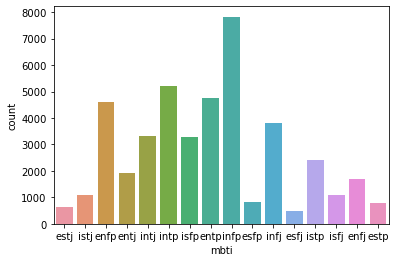

In [33]:
sns.countplot(x='mbti', data=data2)

0.3581980166273504


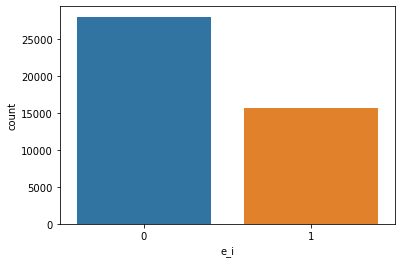

In [34]:
sns.countplot(x='e_i', data=data2)
print(sum(data2.e_i==1)/len(data2))

0.7573460366901037

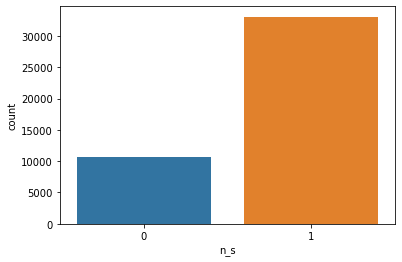

In [35]:
sns.countplot(x='n_s', data=data2)
sum(data2.n_s==1)/len(data2)

0.5400224446327554

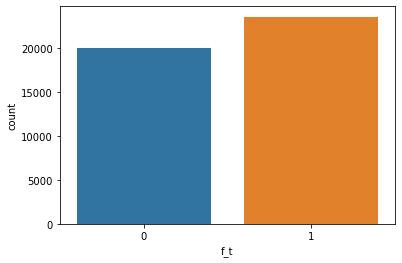

In [36]:
sns.countplot(x='f_t', data=data2)
sum(data2.f_t==1)/len(data2)

0.3208666376565971

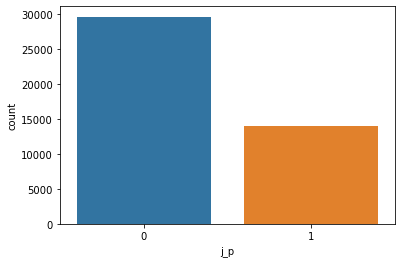

In [37]:
sns.countplot(x='j_p', data=data2)
sum(data2.j_p==1)/len(data2)

In [38]:
# 전처리 후 남은 데이터 percentage
data2.shape[0]/data.shape[0]*100

90.25196882945079